In [ ]:
%pip install pandas numpy scikit-learn imbalanced-learn xgboost seaborn matplotlib

In [ ]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("dhoogla/cicids2017")

print("Path to dataset files:", dataset_path)

100%|██████████| 227M/227M [00:03<00:00, 75.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3


In [ ]:
import os
import pandas as pd

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [ ]:
# =========================================
# DATA CLEANING + PREPARATION
# =========================================
# Collect parquet files
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.parquet')]

# Concatenate parquet files
df = pd.concat((pd.read_parquet(f) for f in all_files), ignore_index=True)
print("Original dataset shape:", df.shape)

# Use a subset of 100,000 rows for faster training
df_sampled = df.sample(n=100000, random_state=42)
X = df_sampled.drop(columns=['Label'])
y = df_sampled['Label']

# Drop non-numeric identifier columns if they exist
drop_cols = [c for c in ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'] if c in X.columns]
X = X.drop(columns=drop_cols, errors='ignore')

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("After cleaning & scaling:", X_scaled.shape, y_encoded.shape)

Original dataset shape: (2313810, 78)
After cleaning & scaling: (100000, 77) (100000,)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== KNN ===
Accuracy: 0.9948
Weighted F1: 0.9945
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25621
           1       0.52      0.62      0.57        21
           2       0.99      0.99      0.99      1640
           3       0.96      0.93      0.94       144
           4       0.99      0.99      0.99      2269
           5       0.90      0.89      0.89        71
           6       0.89      0.86      0.87        64
           7       1.00      0.99      0.99        71
           8       0.00      0.00      0.00         4
           9       0.94      0.67      0.78        24
          10       0.98      0.91      0.95        47
          11       0.62      0.53      0.57        15
          13       0.00      0.00      0.00         9

    accuracy                           0.99     30000
   macro avg       0.75      0.72      0.73     30000
weighted avg       0.99      0.99      0.99     30000



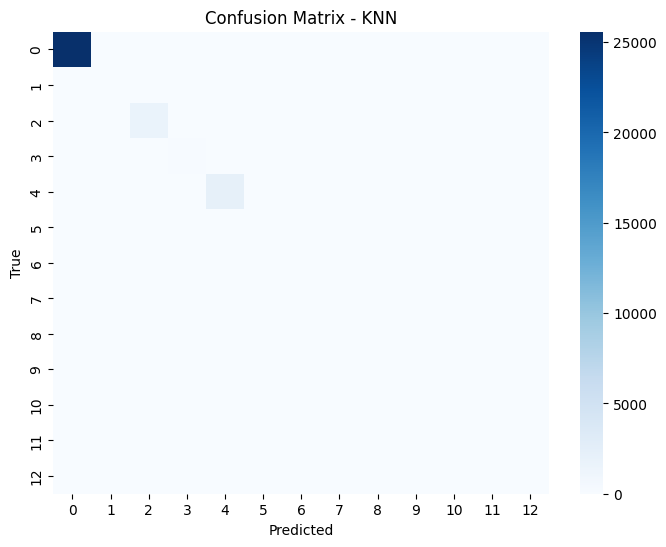

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y_encoded, test_size=0.3, random_state=42 )

# ===============================
# K-Nearest Neighbors
# ===============================
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
report_knn = classification_report(y_test, y_pred_knn)

print("=== KNN ===")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Weighted F1: {f1_knn:.4f}")
print(f"Classification Report:\n{report_knn}")

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_knn, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Logistic Regression ===
Accuracy: 0.9775
Weighted F1: 0.9739
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25621
           1       0.00      0.00      0.00        21
           2       0.99      0.90      0.95      1640
           3       0.97      0.80      0.88       144
           4       0.99      0.90      0.95      2269
           5       0.85      0.66      0.75        71
           6       0.83      0.55      0.66        64
           7       0.00      0.00      0.00        71
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00        24
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00        15
          13       0.00      0.00      0.00         9

    accuracy                           0.98     30000
   macro avg       0.43      0.37      0.40     30000
weighted avg       0.97      0.98      0.97   

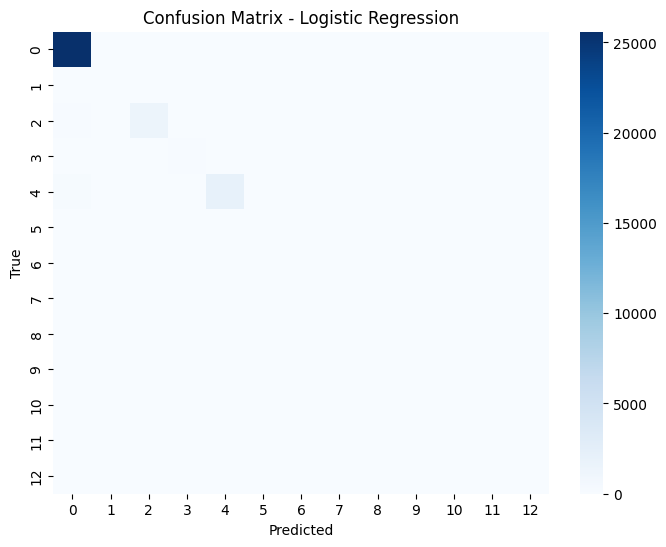

In [ ]:
# ===============================
# Logistic Regression
# ===============================
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear', random_state=42, max_iter=200)
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, average='weighted')
report_logreg = classification_report(y_test, y_pred_logreg)

print("=== Logistic Regression ===")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"Weighted F1: {f1_logreg:.4f}")
print(f"Classification Report:\n{report_logreg}")

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8,6))
sns.heatmap(cm_logreg, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== SVM ===
Accuracy: 0.9847
Weighted F1: 0.9833
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25621
           1       0.00      0.00      0.00        21
           2       1.00      0.96      0.98      1640
           3       0.98      0.85      0.91       144
           4       1.00      0.90      0.95      2269
           5       0.86      0.83      0.84        71
           6       0.93      0.84      0.89        64
           7       0.98      0.58      0.73        71
           8       0.00      0.00      0.00         4
           9       1.00      0.08      0.15        24
          10       0.96      0.91      0.93        47
          11       0.00      0.00      0.00        15
          13       0.00      0.00      0.00         9

    accuracy                           0.98     30000
   macro avg       0.67      0.54      0.57     30000
weighted avg       0.98      0.98      0.98     30000



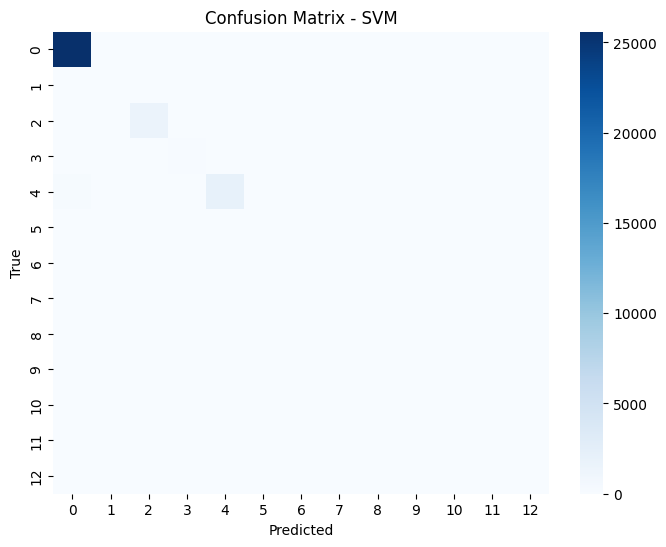

In [ ]:
# ===============================
# Support Vector Machine
# ===============================
from sklearn.svm import SVC

svm_model = SVC(random_state=42, kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
report_svm = classification_report(y_test, y_pred_svm)

print("=== SVM ===")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Weighted F1: {f1_svm:.4f}")
print(f"Classification Report:\n{report_svm}")

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:11:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being s

=== XGBoost ===
Accuracy: 0.9975
Weighted F1: 0.9973
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25621
           1       0.63      0.57      0.60        21
           2       1.00      1.00      1.00      1640
           3       0.99      0.96      0.98       144
           4       1.00      1.00      1.00      2269
           5       0.96      0.94      0.95        71
           6       1.00      0.92      0.96        64
           7       1.00      1.00      1.00        71
           8       0.00      0.00      0.00         4
           9       1.00      0.75      0.86        24
          10       1.00      0.87      0.93        47
          11       0.71      0.80      0.75        15
          13       0.33      0.11      0.17         9

    accuracy                           1.00     30000
   macro avg       0.82      0.76      0.78     30000
weighted avg       1.00      1.00      1.00     30000



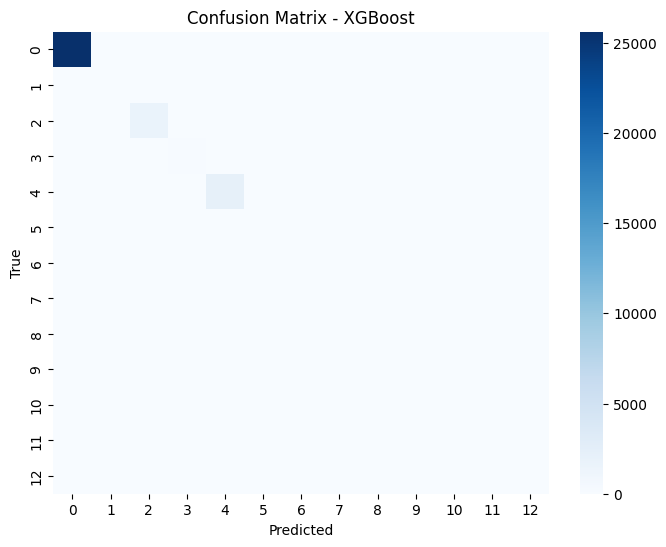

In [ ]:
# ===============================
# XGBoost
# ===============================
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
report_xgb = classification_report(y_test, y_pred_xgb)

print("=== XGBoost ===")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Weighted F1: {f1_xgb:.4f}")
print(f"Classification Report:\n{report_xgb}")

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8,6))
sns.heatmap(cm_xgb, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
